In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)

# Rutas
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'gold' / 'model' / 'clustering_geo_dataset.parquet'

In [2]:
# Cargar datos
df = pd.read_parquet(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"\nColumnas: {df.columns.tolist()}")
df.head()

Shape: (12984, 45)

Columnas: ['codigo_departamento', 'municipio', 'area', 'codigo_municipio', 'departamento', 'Shape_Leng', 'Shape_Area', 'geometry', 'n_centros_poblados', 'anio', 'mes', 'total_delitos', 'ABIGEATO', 'AMENAZAS', 'DELITOS SEXUALES', 'EXTORSION', 'HOMICIDIOS', 'HURTOS', 'LESIONES', 'VIOLENCIA INTRAFAMILIAR', 'femenino_adolescentes', 'femenino_adultos', 'femenino_menores', 'masculino_adolescentes', 'masculino_adultos', 'masculino_menores', 'poblacion_total', 'poblacion_menores', 'poblacion_adultos', 'poblacion_adolescentes', 'area_km2', 'densidad_poblacional', 'centros_por_km2', 'proporcion_menores', 'proporcion_adultos', 'proporcion_adolescentes', 'fecha', 'trimestre', 'anio_mes', 'es_fin_ano', 'n_dias_semana', 'n_fines_de_semana', 'n_festivos', 'n_dias_laborales', 'cluster_delictivo']


,codigo_departamento,municipio,area,codigo_municipio,departamento,Shape_Leng,Shape_Area,geometry,n_centros_poblados,anio,mes,total_delitos,ABIGEATO,AMENAZAS,DELITOS SEXUALES,EXTORSION,HOMICIDIOS,HURTOS,LESIONES,VIOLENCIA INTRAFAMILIAR,femenino_adolescentes,femenino_adultos,femenino_menores,masculino_adolescentes,masculino_adultos,masculino_menores,poblacion_total,poblacion_menores,poblacion_adultos,poblacion_adolescentes,area_km2,densidad_poblacional,centros_por_km2,proporcion_menores,proporcion_adultos,proporcion_adolescentes,fecha,trimestre,anio_mes,es_fin_ano,n_dias_semana,n_fines_de_semana,n_festivos,n_dias_laborales,cluster_delictivo
0,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2010,2,1,0,0,0,0,0,0,1,0,104,1455,289,123,1697,300,3968,589,3152,227,75.231248,52.744041,0.013292,0.148438,0.794355,0.057208,2010-02-01,1,2010-02,0,0,1,0,0,0
1,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2011,1,3,0,1,0,0,0,0,2,0,103,1438,275,118,1672,290,3896,565,3110,221,75.231248,51.786992,0.013292,0.145021,0.798255,0.056725,2011-01-01,1,2011-01,0,0,2,0,0,0
2,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2011,4,1,0,1,0,0,0,0,0,0,103,1438,275,118,1672,290,3896,565,3110,221,75.231248,51.786992,0.013292,0.145021,0.798255,0.056725,2011-04-01,2,2011-04,0,0,1,0,0,0
3,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2011,5,1,0,1,0,0,0,0,0,0,103,1438,275,118,1672,290,3896,565,3110,221,75.231248,51.786992,0.013292,0.145021,0.798255,0.056725,2011-05-01,2,2011-05,0,1,0,0,1,0
4,68,AGUADA,75.231248,68013,SANTANDER,0.47581,0.006146,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,1,2011,6,1,0,0,0,0,0,0,1,0,103,1438,275,118,1672,290,3896,565,3110,221,75.231248,51.786992,0.013292,0.145021,0.798255,0.056725,2011-06-01,2,2011-06,0,1,0,0,1,0


In [3]:
# Info general
print("=" * 60)
print("INFO GENERAL")
print("=" * 60)
print(f"\nTotal registros: {len(df):,}")
print(f"Período: {df['anio'].min()} - {df['anio'].max()}")
print(f"Municipios: {df['codigo_municipio'].nunique()}")
print(f"Clusters: {df['cluster_delictivo'].unique()}")

INFO GENERAL

Total registros: 12,984
Período: 2010 - 2025
Municipios: 87
Clusters: [0 2 1 3]


## 1. Distribución de Clusters

In [4]:
# Distribución de clusters
print("=" * 60)
print("DISTRIBUCIÓN DE CLUSTERS")
print("=" * 60)

cluster_counts = df['cluster_delictivo'].value_counts().sort_index()
cluster_pct = df['cluster_delictivo'].value_counts(normalize=True).sort_index() * 100

balance_cluster = pd.DataFrame({
    'count': cluster_counts,
    'porcentaje': cluster_pct.round(2)
})
print(balance_cluster)

# Ratio de desbalance
ratio = cluster_counts.max() / cluster_counts.min()
print(f"\nRatio max/min: {ratio:.2f}")

DISTRIBUCIÓN DE CLUSTERS
                   count  porcentaje
cluster_delictivo                   
0                  12034       92.68
1                    190        1.46
2                    664        5.11
3                     96        0.74

Ratio max/min: 125.35


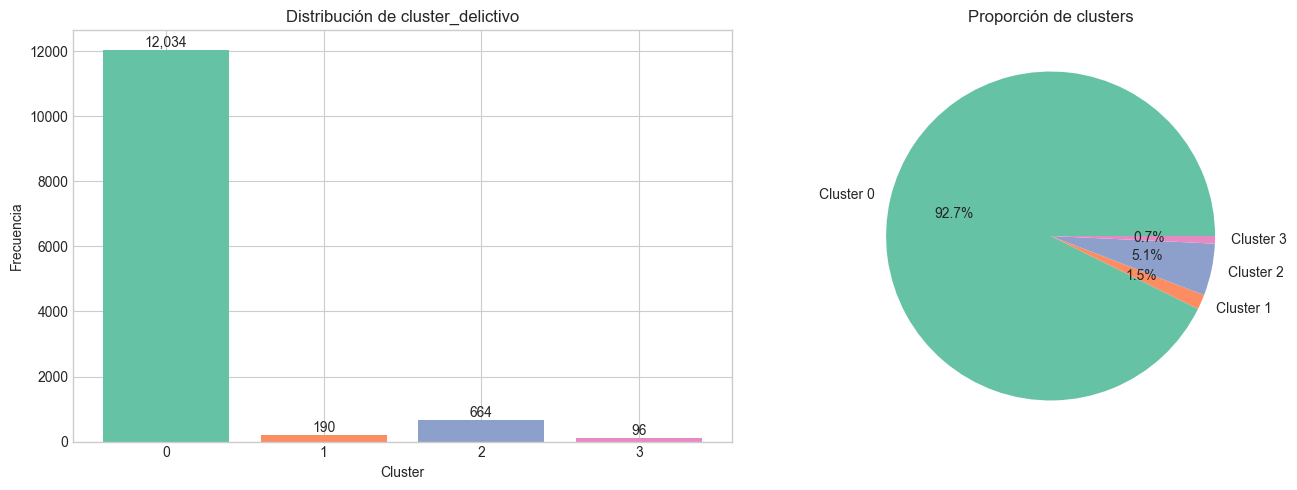

In [5]:
# Visualización distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = sns.color_palette('Set2', len(cluster_counts))

# Barplot
ax1 = axes[0]
bars = ax1.bar(cluster_counts.index.astype(str), cluster_counts.values, color=colors)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de cluster_delictivo')
for bar, val in zip(bars, cluster_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 100, f'{val:,}', ha='center')

# Pie chart
ax2 = axes[1]
ax2.pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index], 
        autopct='%1.1f%%', colors=colors)
ax2.set_title('Proporción de clusters')

plt.tight_layout()
plt.show()

## 2. Características por Cluster

In [6]:
# Características promedio por cluster
print("=" * 60)
print("CARACTERÍSTICAS PROMEDIO POR CLUSTER")
print("=" * 60)

feature_cols = ['total_delitos', 'poblacion_total', 'densidad_poblacional', 
                'area_km2', 'n_centros_poblados']

cluster_stats = df.groupby('cluster_delictivo')[feature_cols].mean().round(2)
print(cluster_stats)

# Interpretación
print("\n" + "-" * 60)
print("INTERPRETACIÓN DE CLUSTERS:")
for cluster in sorted(df['cluster_delictivo'].unique()):
    stats = cluster_stats.loc[cluster]
    print(f"\nCluster {cluster}:")
    print(f"  - Delitos promedio: {stats['total_delitos']:.0f}")
    print(f"  - Población promedio: {stats['poblacion_total']:,.0f}")
    print(f"  - Densidad: {stats['densidad_poblacional']:.1f} hab/km²")

CARACTERÍSTICAS PROMEDIO POR CLUSTER
                   total_delitos  poblacion_total  densidad_poblacional  \
cluster_delictivo                                                         
0                           8.95         16589.68                 85.93   
1                         674.09        566636.83               4620.41   
2                         251.68        273349.39                811.22   
3                         825.67       1053540.50               6889.68   

                   area_km2  n_centros_poblados  
cluster_delictivo                                
0                    390.10                4.56  
1                    126.34                3.53  
2                    673.61                6.00  
3                    152.92                1.00  

------------------------------------------------------------
INTERPRETACIÓN DE CLUSTERS:

Cluster 0:
  - Delitos promedio: 9
  - Población promedio: 16,590
  - Densidad: 85.9 hab/km²

Cluster 1:
  - Delitos prom

C:\Users\57318\AppData\Local\Temp\ipykernel_4520\3030669416.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster_delictivo', y=feature, palette=palette, ax=ax)
C:\Users\57318\AppData\Local\Temp\ipykernel_4520\3030669416.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster_delictivo', y=feature, palette=palette, ax=ax)
C:\Users\57318\AppData\Local\Temp\ipykernel_4520\3030669416.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster_delictivo', y=feature, palette=palette, ax=ax)
C:\Users\5

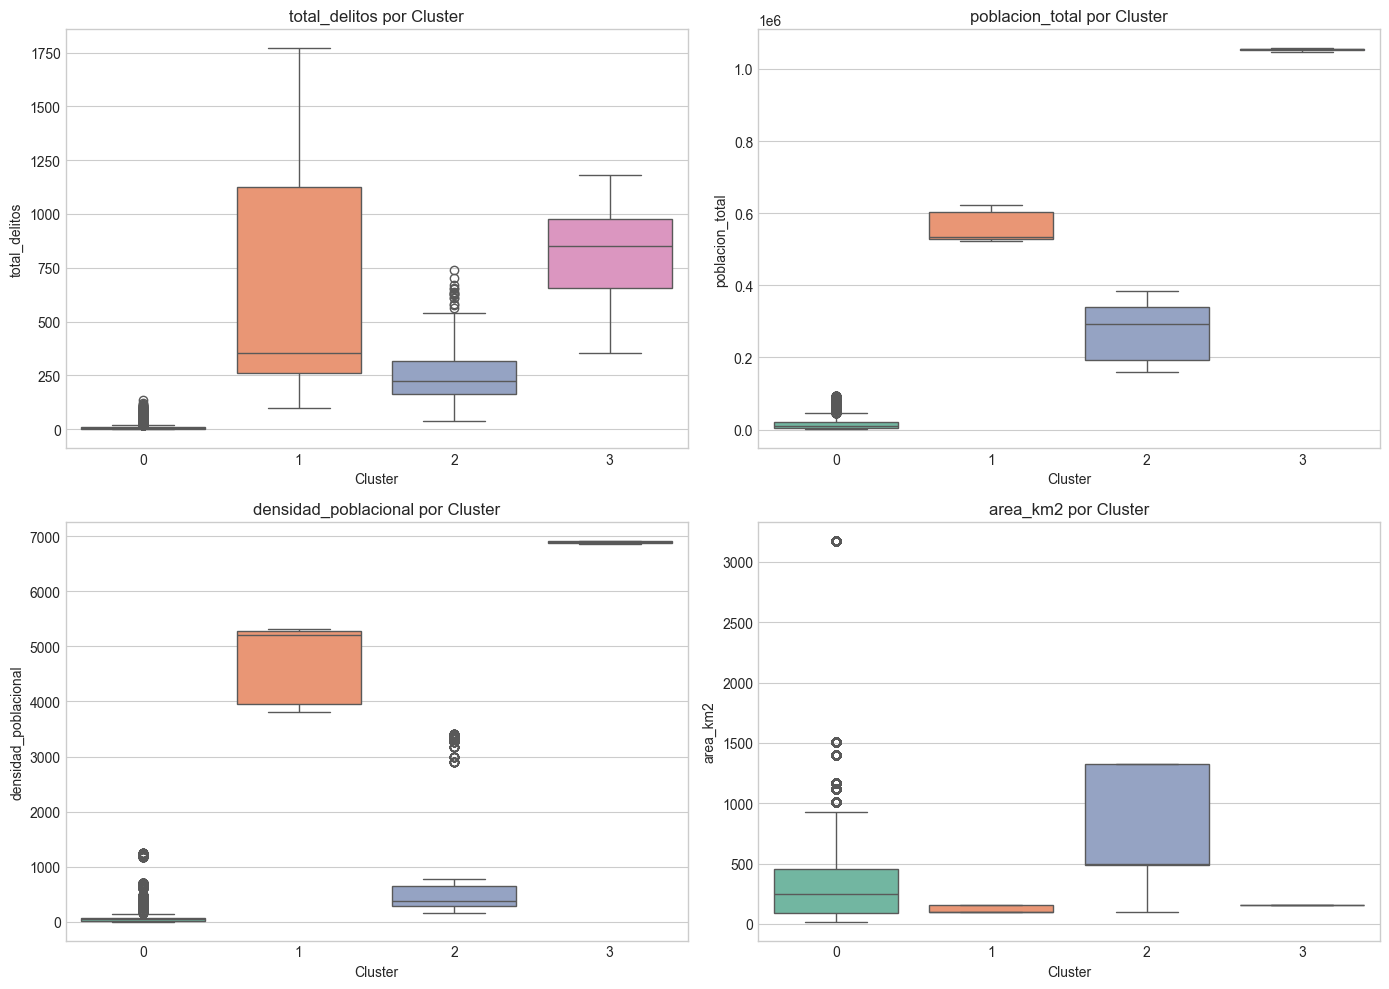

In [7]:
# Boxplots por cluster
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features_to_plot = ['total_delitos', 'poblacion_total', 'densidad_poblacional', 'area_km2']
palette = sns.color_palette('Set2', len(cluster_counts))

for ax, feature in zip(axes.flat, features_to_plot):
    sns.boxplot(data=df, x='cluster_delictivo', y=feature, palette=palette, ax=ax)
    ax.set_title(f'{feature} por Cluster')
    ax.set_xlabel('Cluster')

plt.tight_layout()
plt.show()

## 3. Validación del Clustering

In [8]:
# Métricas de validación del clustering
print("=" * 60)
print("MÉTRICAS DE VALIDACIÓN")
print("=" * 60)

# Features usadas para clustering
cluster_features = ['total_delitos', 'poblacion_total', 'densidad_poblacional']

# Eliminar NaN para el cálculo
df_valid = df.dropna(subset=cluster_features + ['cluster_delictivo'])

X = df_valid[cluster_features].values
labels = df_valid['cluster_delictivo'].values

# Escalar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Silhouette Score (mayor es mejor, rango -1 a 1)
silhouette = silhouette_score(X_scaled, labels)
print(f"\nSilhouette Score: {silhouette:.4f}")
if silhouette > 0.5:
    print("  ✅ Estructura de clusters fuerte")
elif silhouette > 0.25:
    print("  ⚡ Estructura de clusters razonable")
else:
    print("  ⚠️ Estructura de clusters débil")

# Calinski-Harabasz Score (mayor es mejor)
calinski = calinski_harabasz_score(X_scaled, labels)
print(f"\nCalinski-Harabasz Score: {calinski:.2f}")

MÉTRICAS DE VALIDACIÓN

Silhouette Score: 0.8831
  ✅ Estructura de clusters fuerte

Calinski-Harabasz Score: 27423.36


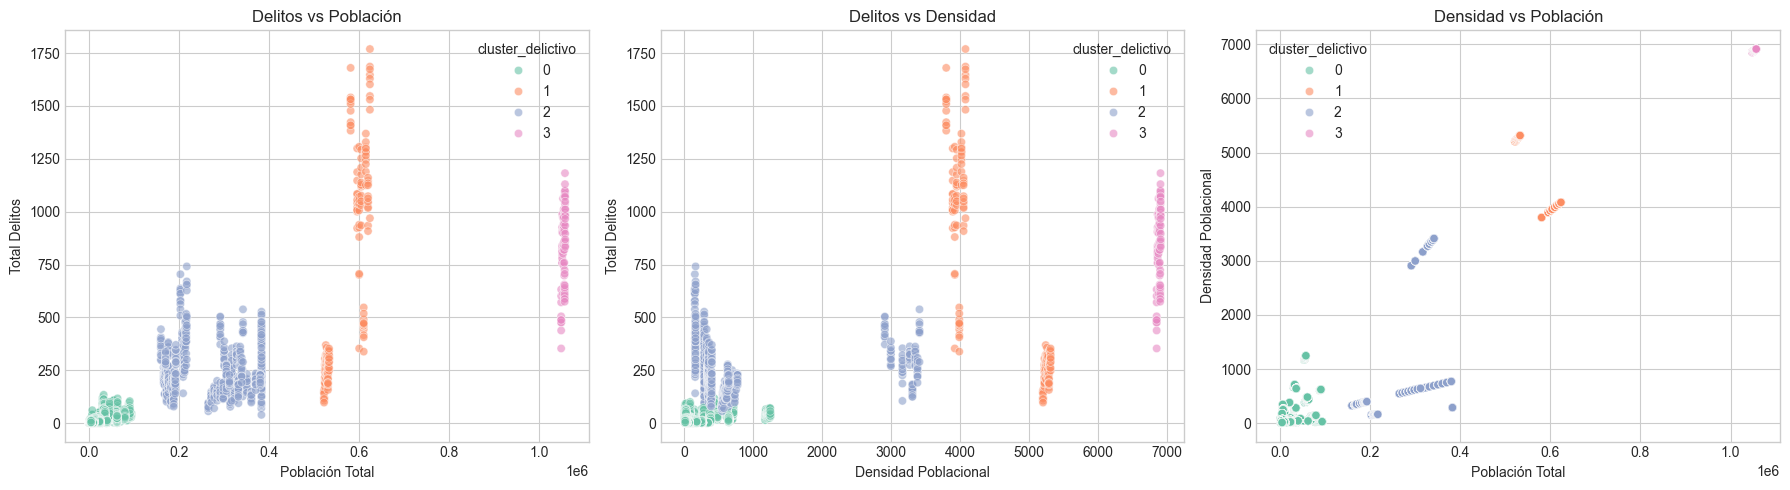

In [9]:
# Scatter plot 2D de clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

palette = sns.color_palette('Set2', len(cluster_counts))

# Delitos vs Población
sns.scatterplot(data=df, x='poblacion_total', y='total_delitos', 
                hue='cluster_delictivo', palette=palette, alpha=0.6, ax=axes[0])
axes[0].set_title('Delitos vs Población')
axes[0].set_xlabel('Población Total')
axes[0].set_ylabel('Total Delitos')

# Delitos vs Densidad
sns.scatterplot(data=df, x='densidad_poblacional', y='total_delitos', 
                hue='cluster_delictivo', palette=palette, alpha=0.6, ax=axes[1])
axes[1].set_title('Delitos vs Densidad')
axes[1].set_xlabel('Densidad Poblacional')
axes[1].set_ylabel('Total Delitos')

# Población vs Densidad
sns.scatterplot(data=df, x='poblacion_total', y='densidad_poblacional', 
                hue='cluster_delictivo', palette=palette, alpha=0.6, ax=axes[2])
axes[2].set_title('Densidad vs Población')
axes[2].set_xlabel('Población Total')
axes[2].set_ylabel('Densidad Poblacional')

plt.tight_layout()
plt.show()

## 4. Municipios por Cluster

In [10]:
# Municipios únicos por cluster
print("=" * 60)
print("MUNICIPIOS POR CLUSTER")
print("=" * 60)

# Obtener municipio más frecuente por cluster para cada código
if 'municipio' in df.columns:
    for cluster in sorted(df['cluster_delictivo'].unique()):
        municipios = df[df['cluster_delictivo'] == cluster]['municipio'].unique()
        print(f"\nCluster {cluster} ({len(municipios)} municipios):")
        print(f"  {', '.join(municipios[:10])}" + ("..." if len(municipios) > 10 else ""))
else:
    for cluster in sorted(df['cluster_delictivo'].unique()):
        codigos = df[df['cluster_delictivo'] == cluster]['codigo_municipio'].unique()
        print(f"\nCluster {cluster} ({len(codigos)} códigos municipio):")
        print(f"  {codigos[:10]}" + ("..." if len(codigos) > 10 else ""))

MUNICIPIOS POR CLUSTER

Cluster 0 (82 municipios):
  AGUADA, ALBANIA, ARATOCA, BARBOSA, BARICHARA, BETULIA, CABRERA, CALIFORNIA, CAPITANEJO, CARCASÍ...

Cluster 1 (2 municipios):
  FLORIDABLANCA, BUCARAMANGA

Cluster 2 (4 municipios):
  BARRANCABERMEJA, GIRÓN, FLORIDABLANCA, PIEDECUESTA

Cluster 3 (1 municipios):
  BUCARAMANGA


## 5. Conclusiones y Recomendaciones

In [11]:
print("=" * 60)
print("CONCLUSIONES")
print("=" * 60)

print(f"""
DISTRIBUCIÓN DE CLUSTERS:
  - El clustering muestra {len(cluster_counts)} grupos diferenciados
  - Existe desbalance significativo (ratio {ratio:.1f})
  - Cluster dominante: {cluster_counts.idxmax()} ({cluster_counts.max():,} registros, {cluster_pct.max():.1f}%)

CALIDAD DEL CLUSTERING:
  - Silhouette Score: {silhouette:.4f}
  - {'✅ Buena separación' if silhouette > 0.25 else '⚠️ Separación débil'}

INTERPRETACIÓN:
  - Cluster 0: Municipios pequeños/rurales (mayoría)
  - Clusters 1-3: Municipios urbanos con mayor actividad delictiva
""")

print("\n" + "=" * 60)
print("RECOMENDACIONES")
print("=" * 60)
print("""
1. El clustering existente es útil como feature para otros modelos
2. Considerar experimentar con más/menos clusters (3-6)
3. Agregar features adicionales: área, tipo de delitos predominantes
4. Para clasificación supervisada: usar cluster_delictivo como target
5. Para nuevos datos: entrenar KMeans y predecir cluster
""")

CONCLUSIONES

DISTRIBUCIÓN DE CLUSTERS:
  - El clustering muestra 4 grupos diferenciados
  - Existe desbalance significativo (ratio 125.4)
  - Cluster dominante: 0 (12,034 registros, 92.7%)

CALIDAD DEL CLUSTERING:
  - Silhouette Score: 0.8831
  - ✅ Buena separación

INTERPRETACIÓN:
  - Cluster 0: Municipios pequeños/rurales (mayoría)
  - Clusters 1-3: Municipios urbanos con mayor actividad delictiva


RECOMENDACIONES

1. El clustering existente es útil como feature para otros modelos
2. Considerar experimentar con más/menos clusters (3-6)
3. Agregar features adicionales: área, tipo de delitos predominantes
4. Para clasificación supervisada: usar cluster_delictivo como target
5. Para nuevos datos: entrenar KMeans y predecir cluster



## 6. Guardar Dataset Procesado

In [12]:
# Ruta para guardar dataset procesado
PROCESSED_DATA_PATH = BASE_DIR / 'data' / 'model' / 'clustering_geo_dataset_processed.parquet'

# Crear carpeta si no existe
PROCESSED_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

# Guardar dataset
df.to_parquet(PROCESSED_DATA_PATH, index=False)
print(f"✓ Dataset procesado guardado: {PROCESSED_DATA_PATH}")
print(f"  Shape: {df.shape}")
print(f"\nDataset contiene:")
print(f"  - Clusters geográfico-delictivos: {len(cluster_counts)} clusters")
print(f"  - Período: {df['anio'].min()} - {df['anio'].max()}")
print(f"  - Municipios: {df['codigo_municipio'].nunique()}")
print(f"  - Target: cluster_delictivo (uso para análisis exploratorio y mapas)")

✓ Dataset procesado guardado: C:\Users\57318\Downloads\mintic\Datos-al-Ecosistema\data\model\clustering_geo_dataset_processed.parquet
  Shape: (12984, 45)

Dataset contiene:
  - Clusters geográfico-delictivos: 4 clusters
  - Período: 2010 - 2025
  - Municipios: 87
  - Target: cluster_delictivo (uso para análisis exploratorio y mapas)
